# K Nearest Neighbors classification walkthrough

In this notebook we are going to look at how the kNN algorithm classifies malignant vs. benign tumor category in the Wisconsin breast cancer dataset.

## 1. Import necessary packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# seaborn is a nice package for plotting, but you have to use pip to install
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier

## 2. Load in the dataset

Path is provided.

In [2]:
bcw = pd.read_csv('../assets/datasets/wdbc.data', header=None, index_col=None)

### 2.2 Assign the columns

The attributes below will be the columns of the dataset.

      Attribute                     
   --------------------------------------------
   1. Sample code number [subject ID]
   2. Class
   3. Cell nucleus mean radius
   4. Cell nucleus SE radius
   5. Cell nucleus worst radius
   6. Texture mean
   7. Texture SE
   8. Texture worst
   9. Perimeter mean
   10. Perimeter SE
   11. Perimeter worst
   12. Area mean
   13. Area SE
   14. Area worst
   15. Smoothness mean
   16. Smoothness SE
   17. Smoothness worst
   18. Compactness mean
   19. Compactness SE
   20. Compactness worst
   21. Concavity mean
   22. Concavity SE
   23. Concavity worst
   24. Concave points mean
   25. Concave points SE
   26. Concave points worst
   27. Symmetry mean
   28. Symmetry SE
   29. Symmetry worst
   30. Fractal dimension mean
   31. Fractal dimension SE
   32. Fractal dimension worst

The column names are taken from the dataset info file. 

For more information check out the information file:

`../assets/datasets/wdbc.names`

You can open it with a text editor of your choice.

Create an array with the column names and assign them as the header when loading the csv.

In [3]:
column_names = ['id','malignant',
                'nucleus_mean','nucleus_se','nucleus_worst',
                'texture_mean','texture_se','texture_worst',
                'perimeter_mean','perimeter_se','perimeter_worst',
                'area_mean','area_se','area_worst',
                'smoothness_mean','smoothness_se','smoothness_worst',
                'compactness_mean','compactness_se','compactness_worst',
                'concavity_mean','concavity_se','concavity_worst',
                'concave_pts_mean','concave_pts_se','concave_pts_worst',
                'symmetry_mean','symmetry_se','symmetry_worst',
                'fractal_dim_mean','fractal_dim_se','fractal_dim_worst']

bcw.columns = column_names

### 2. Check out the dataset information

Print out the head and the datatypes.

In [4]:
bcw.head()

,id,malignant,nucleus_mean,nucleus_se,nucleus_worst,texture_mean,texture_se,texture_worst,perimeter_mean,perimeter_se,...,concavity_worst,concave_pts_mean,concave_pts_se,concave_pts_worst,symmetry_mean,symmetry_se,symmetry_worst,fractal_dim_mean,fractal_dim_se,fractal_dim_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
bcw.dtypes

id                     int64
malignant             object
nucleus_mean         float64
nucleus_se           float64
nucleus_worst        float64
texture_mean         float64
texture_se           float64
texture_worst        float64
perimeter_mean       float64
perimeter_se         float64
perimeter_worst      float64
area_mean            float64
area_se              float64
area_worst           float64
smoothness_mean      float64
smoothness_se        float64
smoothness_worst     float64
compactness_mean     float64
compactness_se       float64
compactness_worst    float64
concavity_mean       float64
concavity_se         float64
concavity_worst      float64
concave_pts_mean     float64
concave_pts_se       float64
concave_pts_worst    float64
symmetry_mean        float64
symmetry_se          float64
symmetry_worst       float64
fractal_dim_mean     float64
fractal_dim_se       float64
fractal_dim_worst    float64
dtype: object

### 2.4 Recode the class field to be 0 vs. 1

The malignant class field is coded as "B" for benign and "M" as malignant. 

It is best to recode this to a binary integer for classification, with "1" as malign and "0" as benign (malign is assigned to 1 because our goal is to predict malign tumors with the data).

In [6]:
bcw['malignant'] = bcw['malignant'].map(lambda x: 0 if x == "B" else 1)

In [7]:
print bcw.malignant.dtype

int64


## 3. Break up the data and look at correlations

Split up the data into 3 datasets for the "mean", "standard error", and "worst" statistics on each predictor variable.

---

NOTE: The difference between standard error and standard deviation is subtle:

A new observation has about a 95% chance to be within **2 standard deviations** of the sample mean.

The sample mean has about a 95% chance to be within **2 standard errors** of the real population mean.


In [8]:
# A function that subsets the data to the columns indicating the
# mean, se, or wrong variable types
def df_subsetter(df, suffix):
    column_select = [x for x in bcw.columns if suffix in x]
    bcw_subset = bcw[['id','malignant'] + column_select]
    bcw_subset.columns = [x.replace(suffix, '') for x in bcw_subset.columns]
    return bcw_subset

bcw_mean = df_subsetter(bcw, '_mean')
bcw_se = df_subsetter(bcw, '_se')
bcw_worst = df_subsetter(bcw, '_worst')


In [12]:
bcw_mean.head()

,id,malignant,nucleus,texture,perimeter,area,smoothness,compactness,concavity,concave_pts,symmetry,fractal_dim
0,842302,1,17.99,1001.0,0.3001,0.07871,8.589,0.04904,0.03003,17.33,0.1622,0.2654
1,842517,1,20.57,1326.0,0.0869,0.05667,3.398,0.01308,0.01389,23.41,0.1238,0.1860
2,84300903,1,19.69,1203.0,0.1974,0.05999,4.585,0.04006,0.02250,25.53,0.1444,0.2430
3,84348301,1,11.42,386.1,0.2414,0.09744,3.445,0.07458,0.05963,26.50,0.2098,0.2575
4,84358402,1,20.29,1297.0,0.1980,0.05883,5.438,0.02461,0.01756,16.67,0.1374,0.1625


### 3.1 Examine correlation matrices for the 3 datasets

Look at the correlations between variables for each of the subset datasets, excluding the id column.

1. The mean columns subset
2. The standard error columns subset
3. The "worst value" columns subset

In [9]:
bcw_mean[[x for x in bcw_mean.columns if x not in 'id']].corr()

,malignant,nucleus,texture,perimeter,area,smoothness,compactness,concavity,concave_pts,symmetry,fractal_dim
malignant,1.000000,0.730029,0.708984,0.696360,-0.012838,0.556141,0.292999,-0.006522,0.456903,0.421465,0.793566
nucleus,0.730029,1.000000,0.987357,0.676764,-0.311631,0.674172,0.206000,-0.104321,0.297008,0.119616,0.744214
texture,0.708984,0.987357,1.000000,0.685983,-0.283110,0.726628,0.212583,-0.072497,0.287489,0.123523,0.722017
perimeter,0.696360,0.676764,0.685983,1.000000,0.336783,0.660391,0.670279,0.178009,0.299879,0.448822,0.861323
area,-0.012838,-0.311631,-0.283110,0.336783,1.000000,0.039830,0.559837,0.345007,-0.051269,0.504942,0.175325
smoothness,0.556141,0.674172,0.726628,0.660391,0.039830,1.000000,0.416322,0.266487,0.200371,0.130054,0.554897
compactness,0.292999,0.206000,0.212583,0.670279,0.559837,0.416322,1.000000,0.394713,0.143003,0.227394,0.483208
concavity,-0.006522,-0.104321,-0.072497,0.178009,0.345007,0.266487,0.394713,1.000000,-0.077473,-0.012662,-0.030413
concave_pts,0.456903,0.297008,0.287489,0.299879,-0.051269,0.200371,0.143003,-0.077473,1.000000,0.225429,0.359755
symmetry,0.421465,0.119616,0.123523,0.448822,0.504942,0.130054,0.227394,-0.012662,0.225429,1.000000,0.547691


In [10]:
bcw_se[[x for x in bcw_se.columns if x not in 'id']].corr()

,malignant,nucleus,texture,perimeter,area,smoothness,compactness,concavity,concave_pts,symmetry,fractal_dim
malignant,1.000000,0.415185,0.358560,0.776614,0.567134,0.548236,0.253730,0.077972,0.782914,0.590998,0.416294
nucleus,0.415185,1.000000,-0.023389,0.293464,0.275869,0.259845,0.143293,0.054458,0.358040,0.277830,0.105008
texture,0.358560,-0.023389,1.000000,0.553695,0.301467,0.246552,0.248396,0.283607,0.238853,0.472468,0.394309
perimeter,0.776614,0.293464,0.553695,1.000000,0.698050,0.690299,0.439167,0.257584,0.855923,0.667454,0.375744
area,0.567134,0.275869,0.301467,0.698050,1.000000,0.951830,0.332358,0.227754,0.719684,0.287103,0.094543
smoothness,0.548236,0.259845,0.246552,0.690299,0.951830,1.000000,0.270895,0.127071,0.761213,0.283257,0.074126
compactness,0.253730,0.143293,0.248396,0.439167,0.332358,0.270895,1.000000,0.727372,0.226680,0.484858,0.197788
concavity,0.077972,0.054458,0.283607,0.257584,0.227754,0.127071,0.727372,1.000000,-0.001000,0.390159,0.111094
concave_pts,0.782914,0.358040,0.238853,0.855923,0.719684,0.761213,0.226680,-0.001000,1.000000,0.529408,0.269493
symmetry,0.590998,0.277830,0.472468,0.667454,0.287103,0.283257,0.484858,0.390159,0.529408,1.000000,0.614441


In [11]:
bcw_worst[[x for x in bcw_worst.columns if x not in 'id']].corr()

,malignant,nucleus,texture,perimeter,area,smoothness,compactness,concavity,concave_pts,symmetry,fractal_dim
malignant,1.000000,0.742636,0.596534,0.330499,-0.008303,-0.067016,0.408042,0.776454,0.733825,0.659610,0.323872
nucleus,0.742636,1.000000,0.556936,0.183027,-0.086761,-0.202694,0.407217,0.969476,0.941550,0.563879,0.051019
texture,0.596534,0.556936,1.000000,0.602641,0.046205,0.135299,0.642262,0.535315,0.509604,0.816275,0.687382
perimeter,0.330499,0.183027,0.602641,1.000000,0.128053,0.187321,0.393298,0.185728,0.177193,0.433721,0.438413
area,-0.008303,-0.086761,0.046205,0.128053,1.000000,0.397243,0.230283,-0.111690,-0.083195,-0.068956,-0.045655
smoothness,-0.067016,-0.202694,0.135299,0.187321,0.397243,1.000000,0.328429,-0.230691,-0.182195,-0.058298,0.101480
compactness,0.408042,0.407217,0.642262,0.393298,0.230283,0.328429,1.000000,0.358127,0.342271,0.549592,0.310655
concavity,0.776454,0.969476,0.535315,0.185728,-0.111690,-0.230691,0.358127,1.000000,0.984015,0.573975,0.093492
concave_pts,0.733825,0.941550,0.509604,0.177193,-0.083195,-0.182195,0.342271,0.984015,1.000000,0.543331,0.079647
symmetry,0.659610,0.563879,0.816275,0.433721,-0.068956,-0.058298,0.549592,0.573975,0.543331,1.000000,0.686511


### 3.2 Look at correlations between mean, standard error, and worst within variable

Look at the correlations between each single variables mean, se, and worst value:

In [13]:
# A function that prints the variable name, subsets the data to just
# be columns that have those variable names, and print out the
# correlation between the variables
def variable_corr_printer(df, varname):
    print varname
    df_sub = df[[x for x in df.columns if varname in x]]
    print df_sub.corr()
    print '--------------------------------------------\n'

# get the variable names without the _mean, _se, _worst suffixes and
# remove duplicate names by filtering
varnames = [
    x.replace('_mean','')
    for x in bcw.columns
    if x not in ['id','malignant']
    and '_se' not in x
    and '_worst' not in x
]

for var in varnames:
    variable_corr_printer(bcw, var)

nucleus
               nucleus_mean  nucleus_se  nucleus_worst
nucleus_mean       1.000000    0.323782       0.997855
nucleus_se         0.323782    1.000000       0.329533
nucleus_worst      0.997855    0.329533       1.000000
--------------------------------------------

texture
               texture_mean  texture_se  texture_worst
texture_mean       1.000000    0.177028       0.498502
texture_se         0.177028    1.000000       0.659123
texture_worst      0.498502    0.659123       1.000000
--------------------------------------------

perimeter
                 perimeter_mean  perimeter_se  perimeter_worst
perimeter_mean         1.000000      0.921391         0.500667
perimeter_se           0.921391      1.000000         0.462497
perimeter_worst        0.500667      0.462497         1.000000
--------------------------------------------

area
            area_mean   area_se  area_worst
area_mean    1.000000  0.000111    0.164174
area_se      0.000111  1.000000    0.213247
area_wo

## 4. Use seaborn's pairplot to visualize relationships between variables

Look at the data using seaborn's `pairplot()` function. The hue will be the class variable "malignant". The variables will be the other columns excluding, of course, the subject ID column.

Most of these predictors are highly correlated with the "class" variable. This is already an indication that our classifier is very likely to perform well.

In [14]:
# set the seaborn style to have a white background
sns.set(style="ticks", color_codes=True)

# This function does a pairplot across your variables with the color
# set as the outcome "malignant" class variable
def bcw_pairplotter(df, variables, sample_frac=0.3):
    # sample_frac lets you specify an amount of the data to sample for the plot.
    # this speeds up the function which can take awhile with the full data.
    
    # get the number of rows/data points:
    rows = df.shape[0]
    
    # get downsample indicies for the data, if specified
    if sample_frac < 1.0:
        sample_inds = np.random.choice(range(0,rows), 
                                       size=int(round(rows*sample_frac)), 
                                       replace=False).astype(int)
    
    # make the pairplot for the variables:
    pairs = sns.pairplot(df.iloc[sample_inds, :], 
                         vars=variables, 
                         hue="malignant", 
                         palette=sns.xkcd_palette(['windows blue', 'amber']))


# get out the column variable names to put into the pairplotter function
colvars = [x for x in bcw_mean if x not in ['id','malignant']]

### 4.2 Plot the mean data subset with the pairplotter function

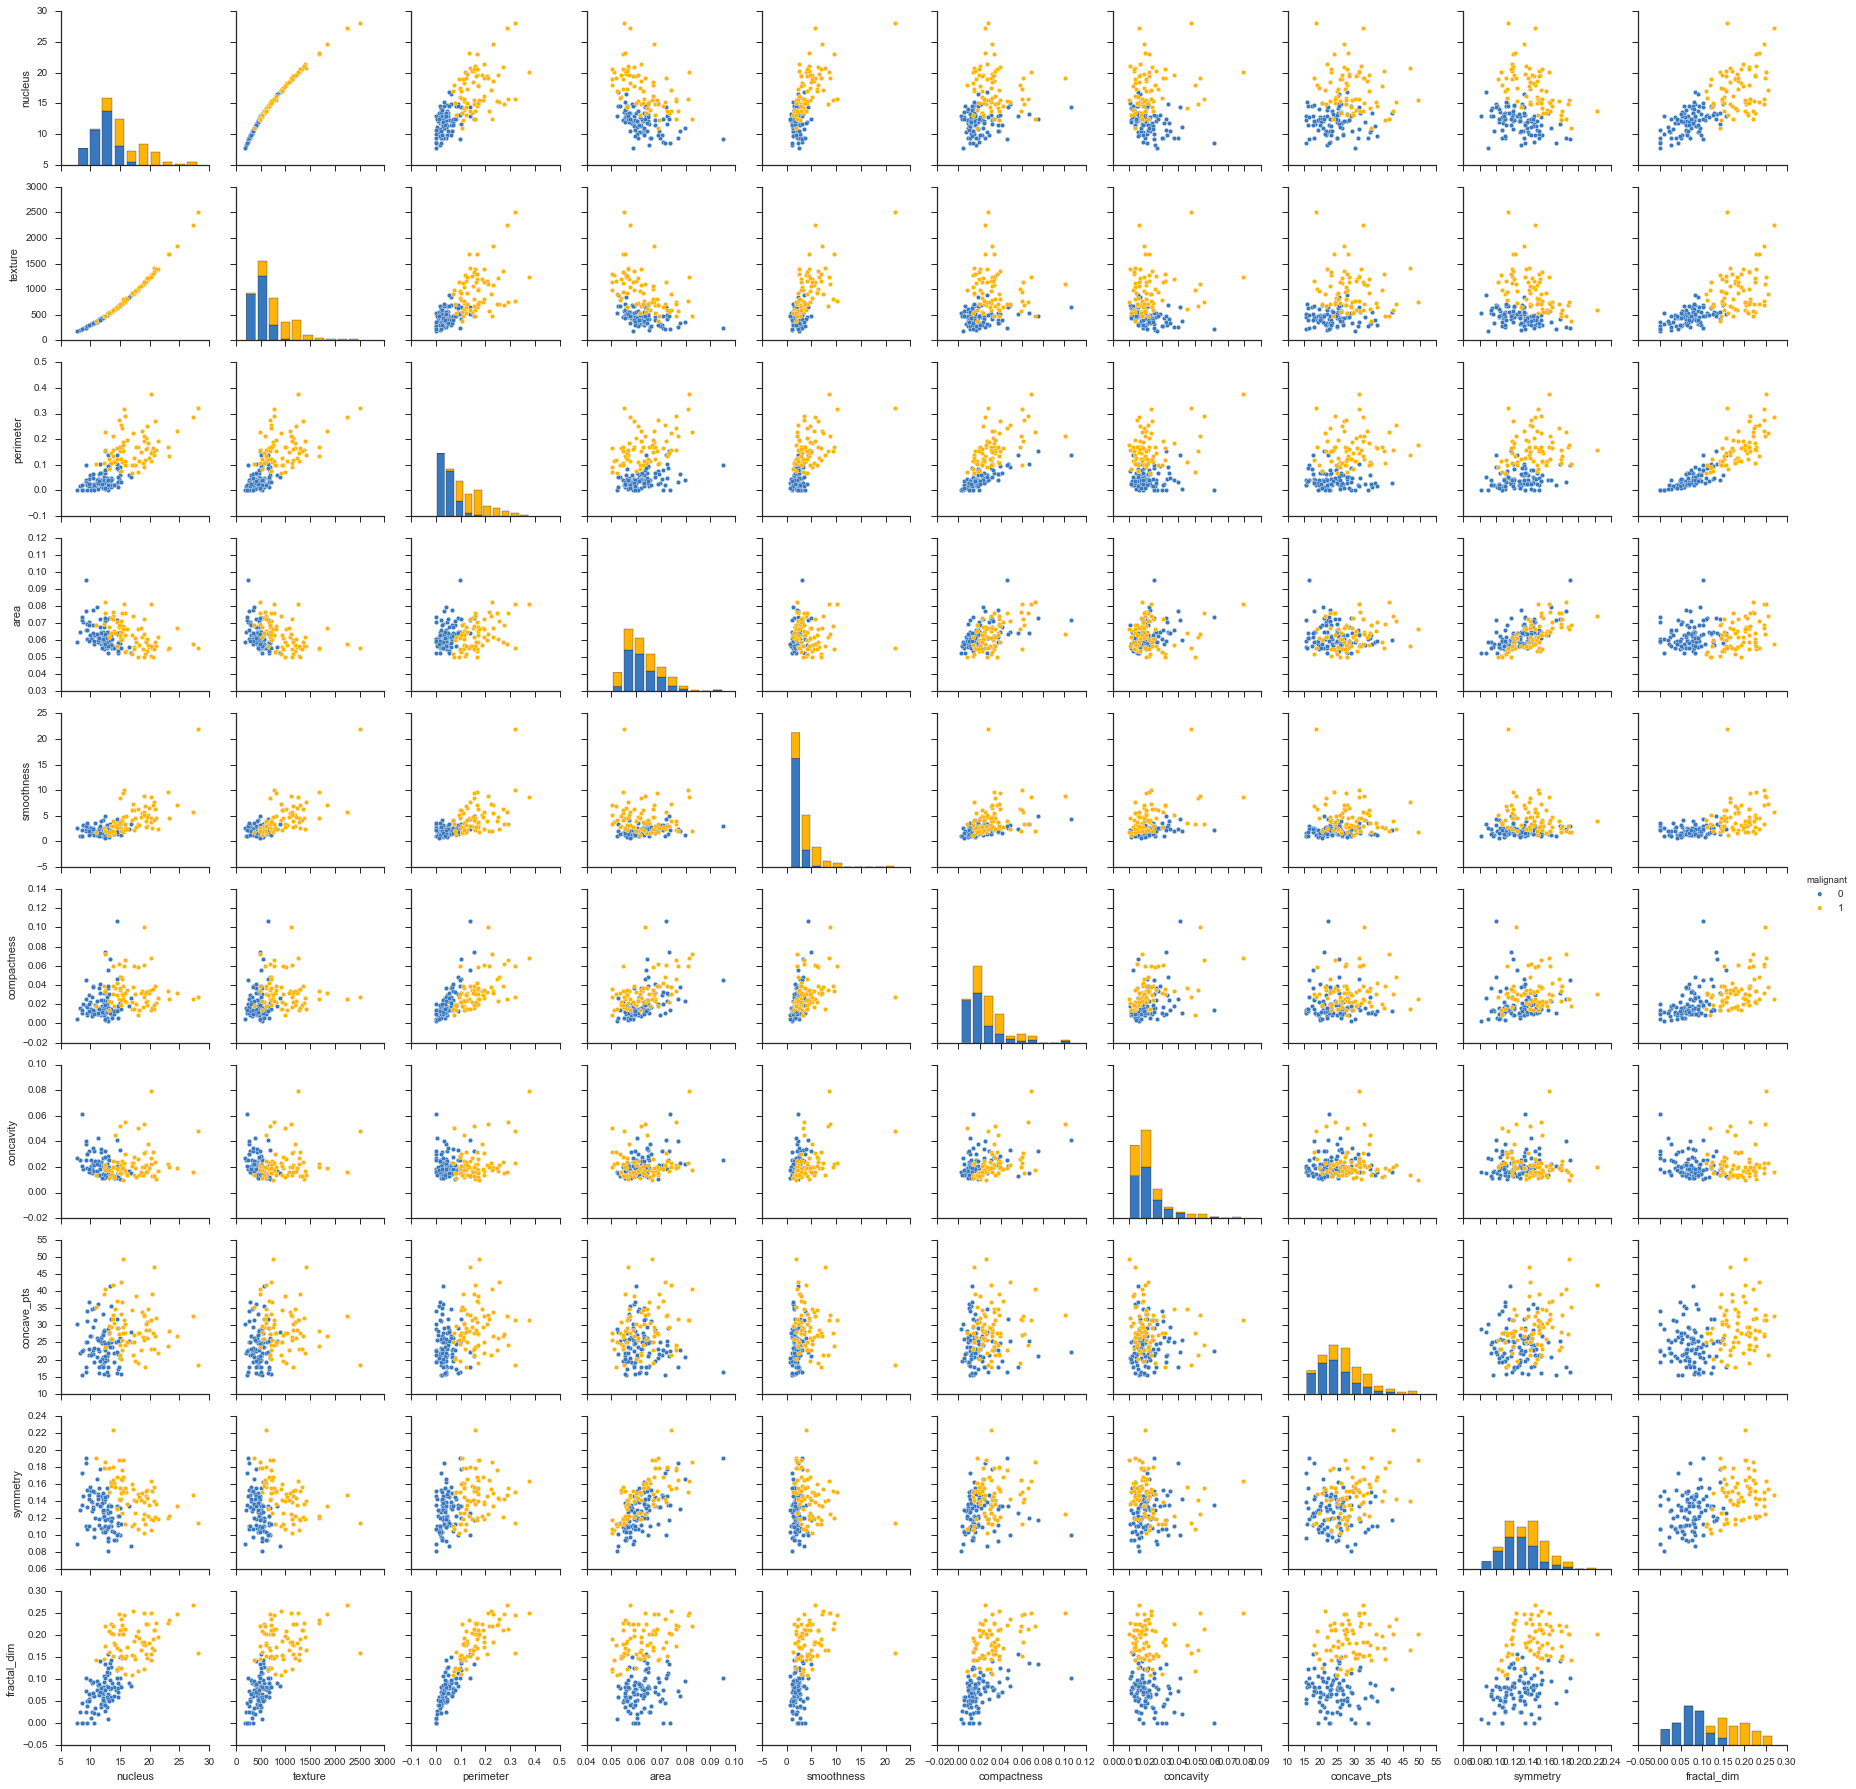

In [15]:
bcw_pairplotter(bcw_mean, colvars)

### 4.3 Plot the standard error data subset with the pairplotter function

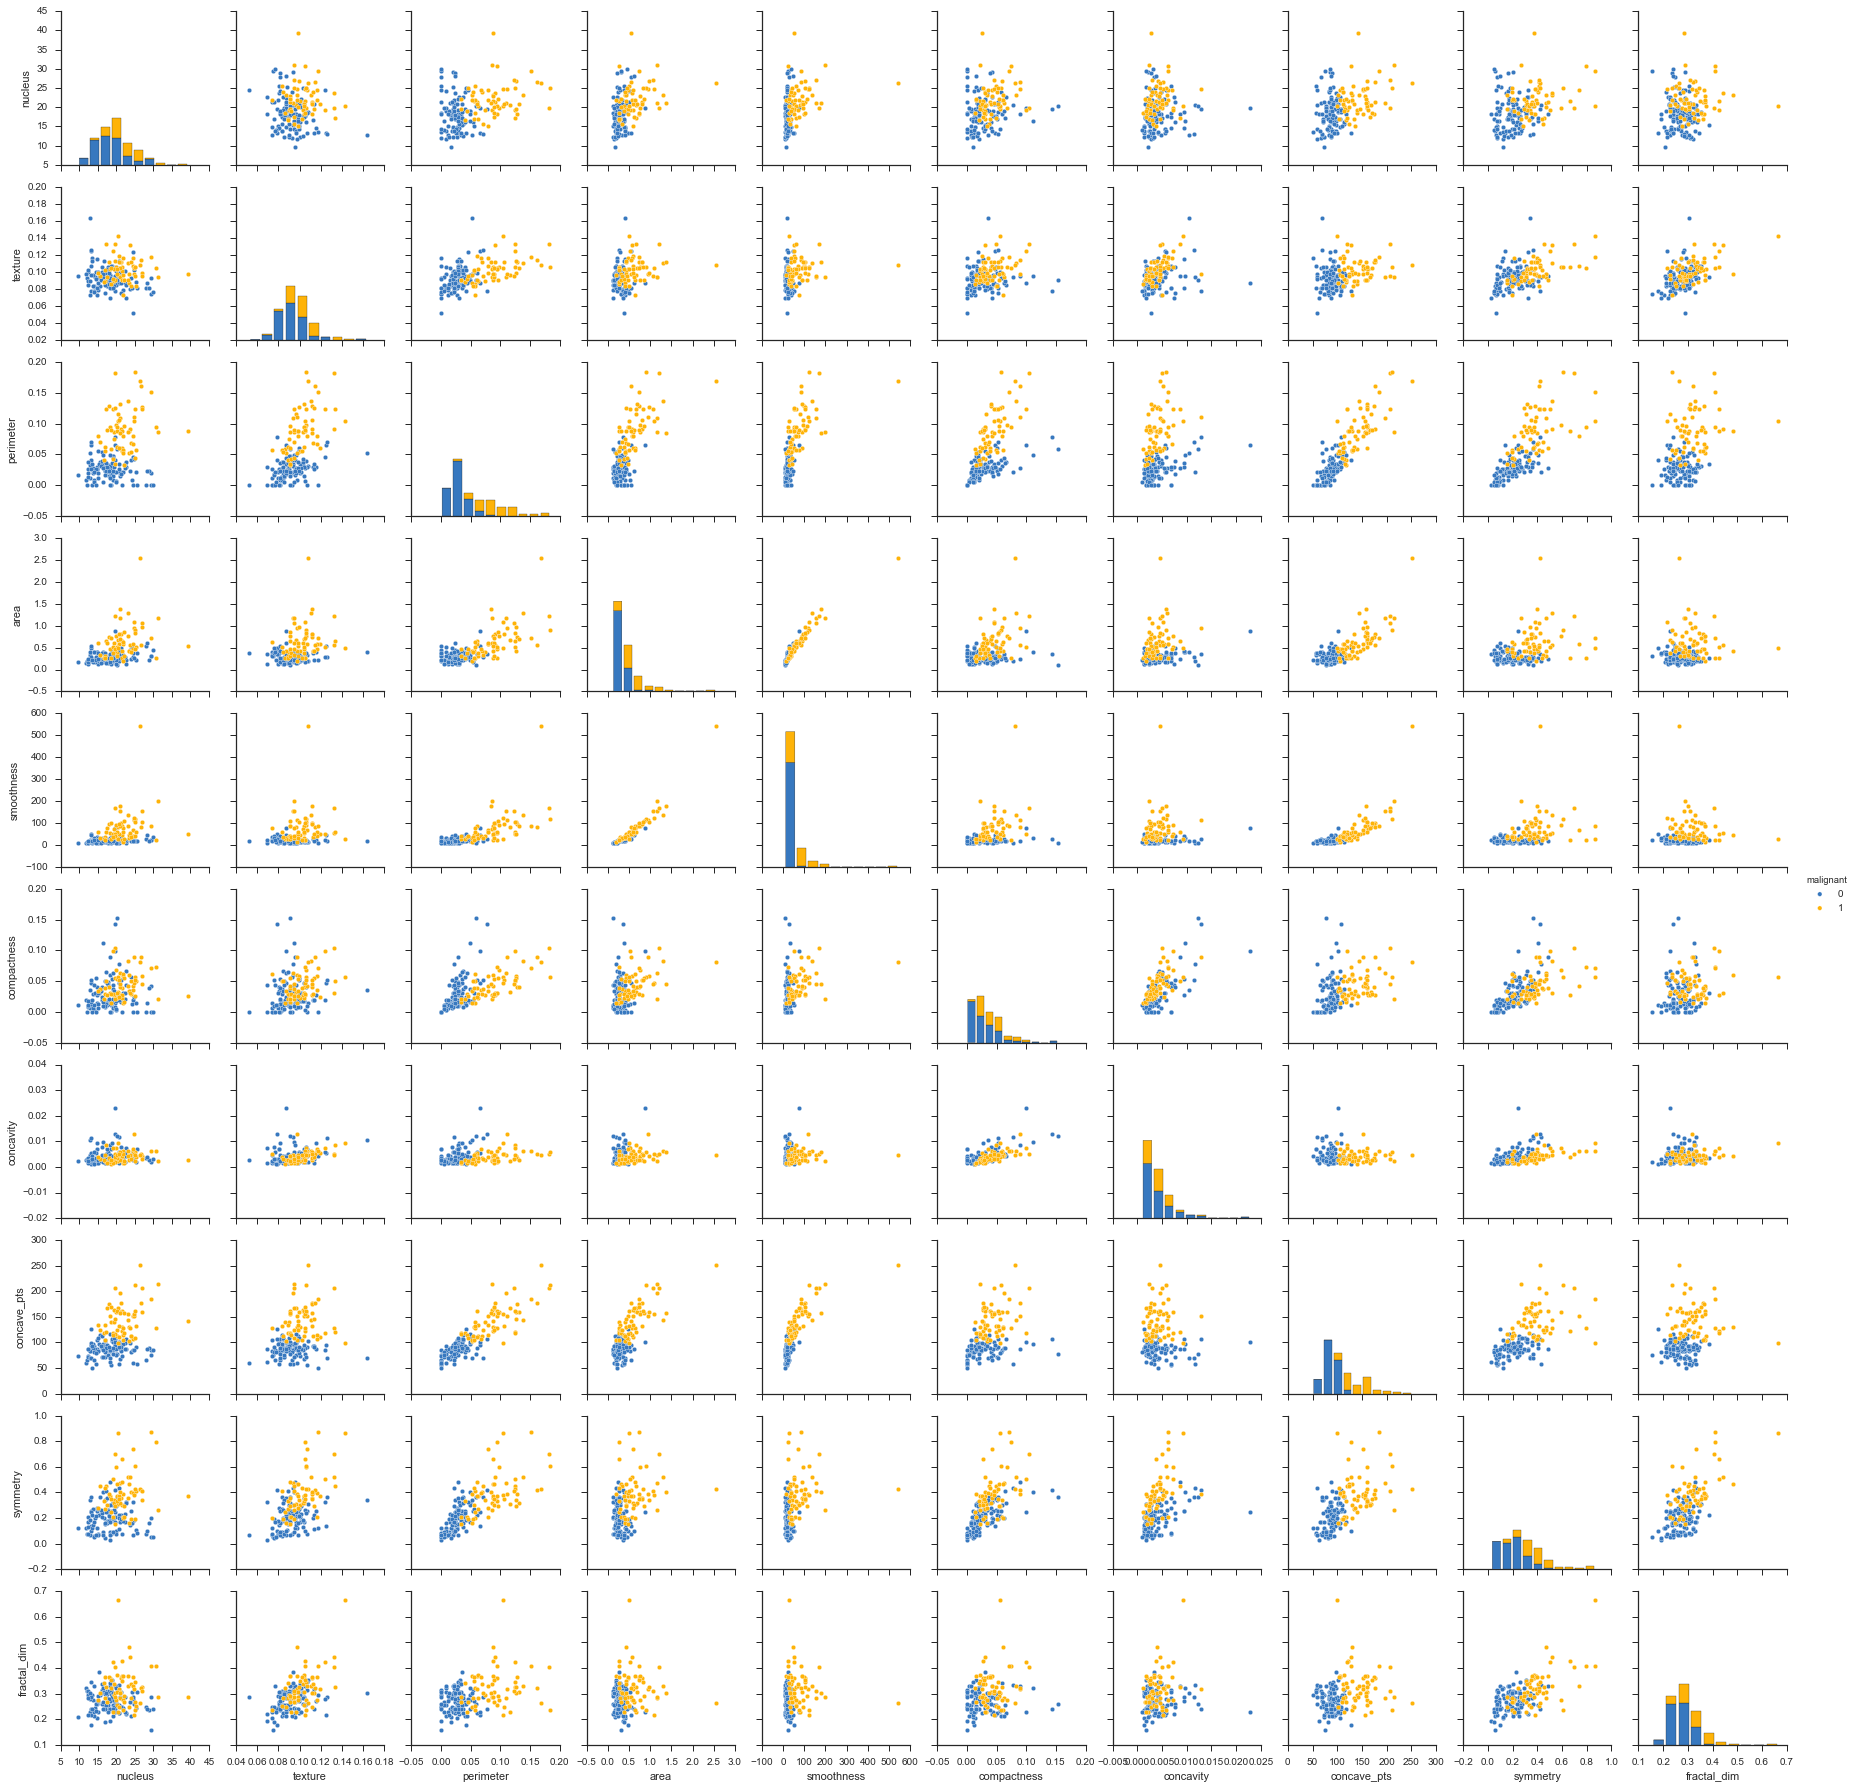

In [16]:
bcw_pairplotter(bcw_se, colvars)

### 4.4 Plot the worst value data subset using the pairplotter function

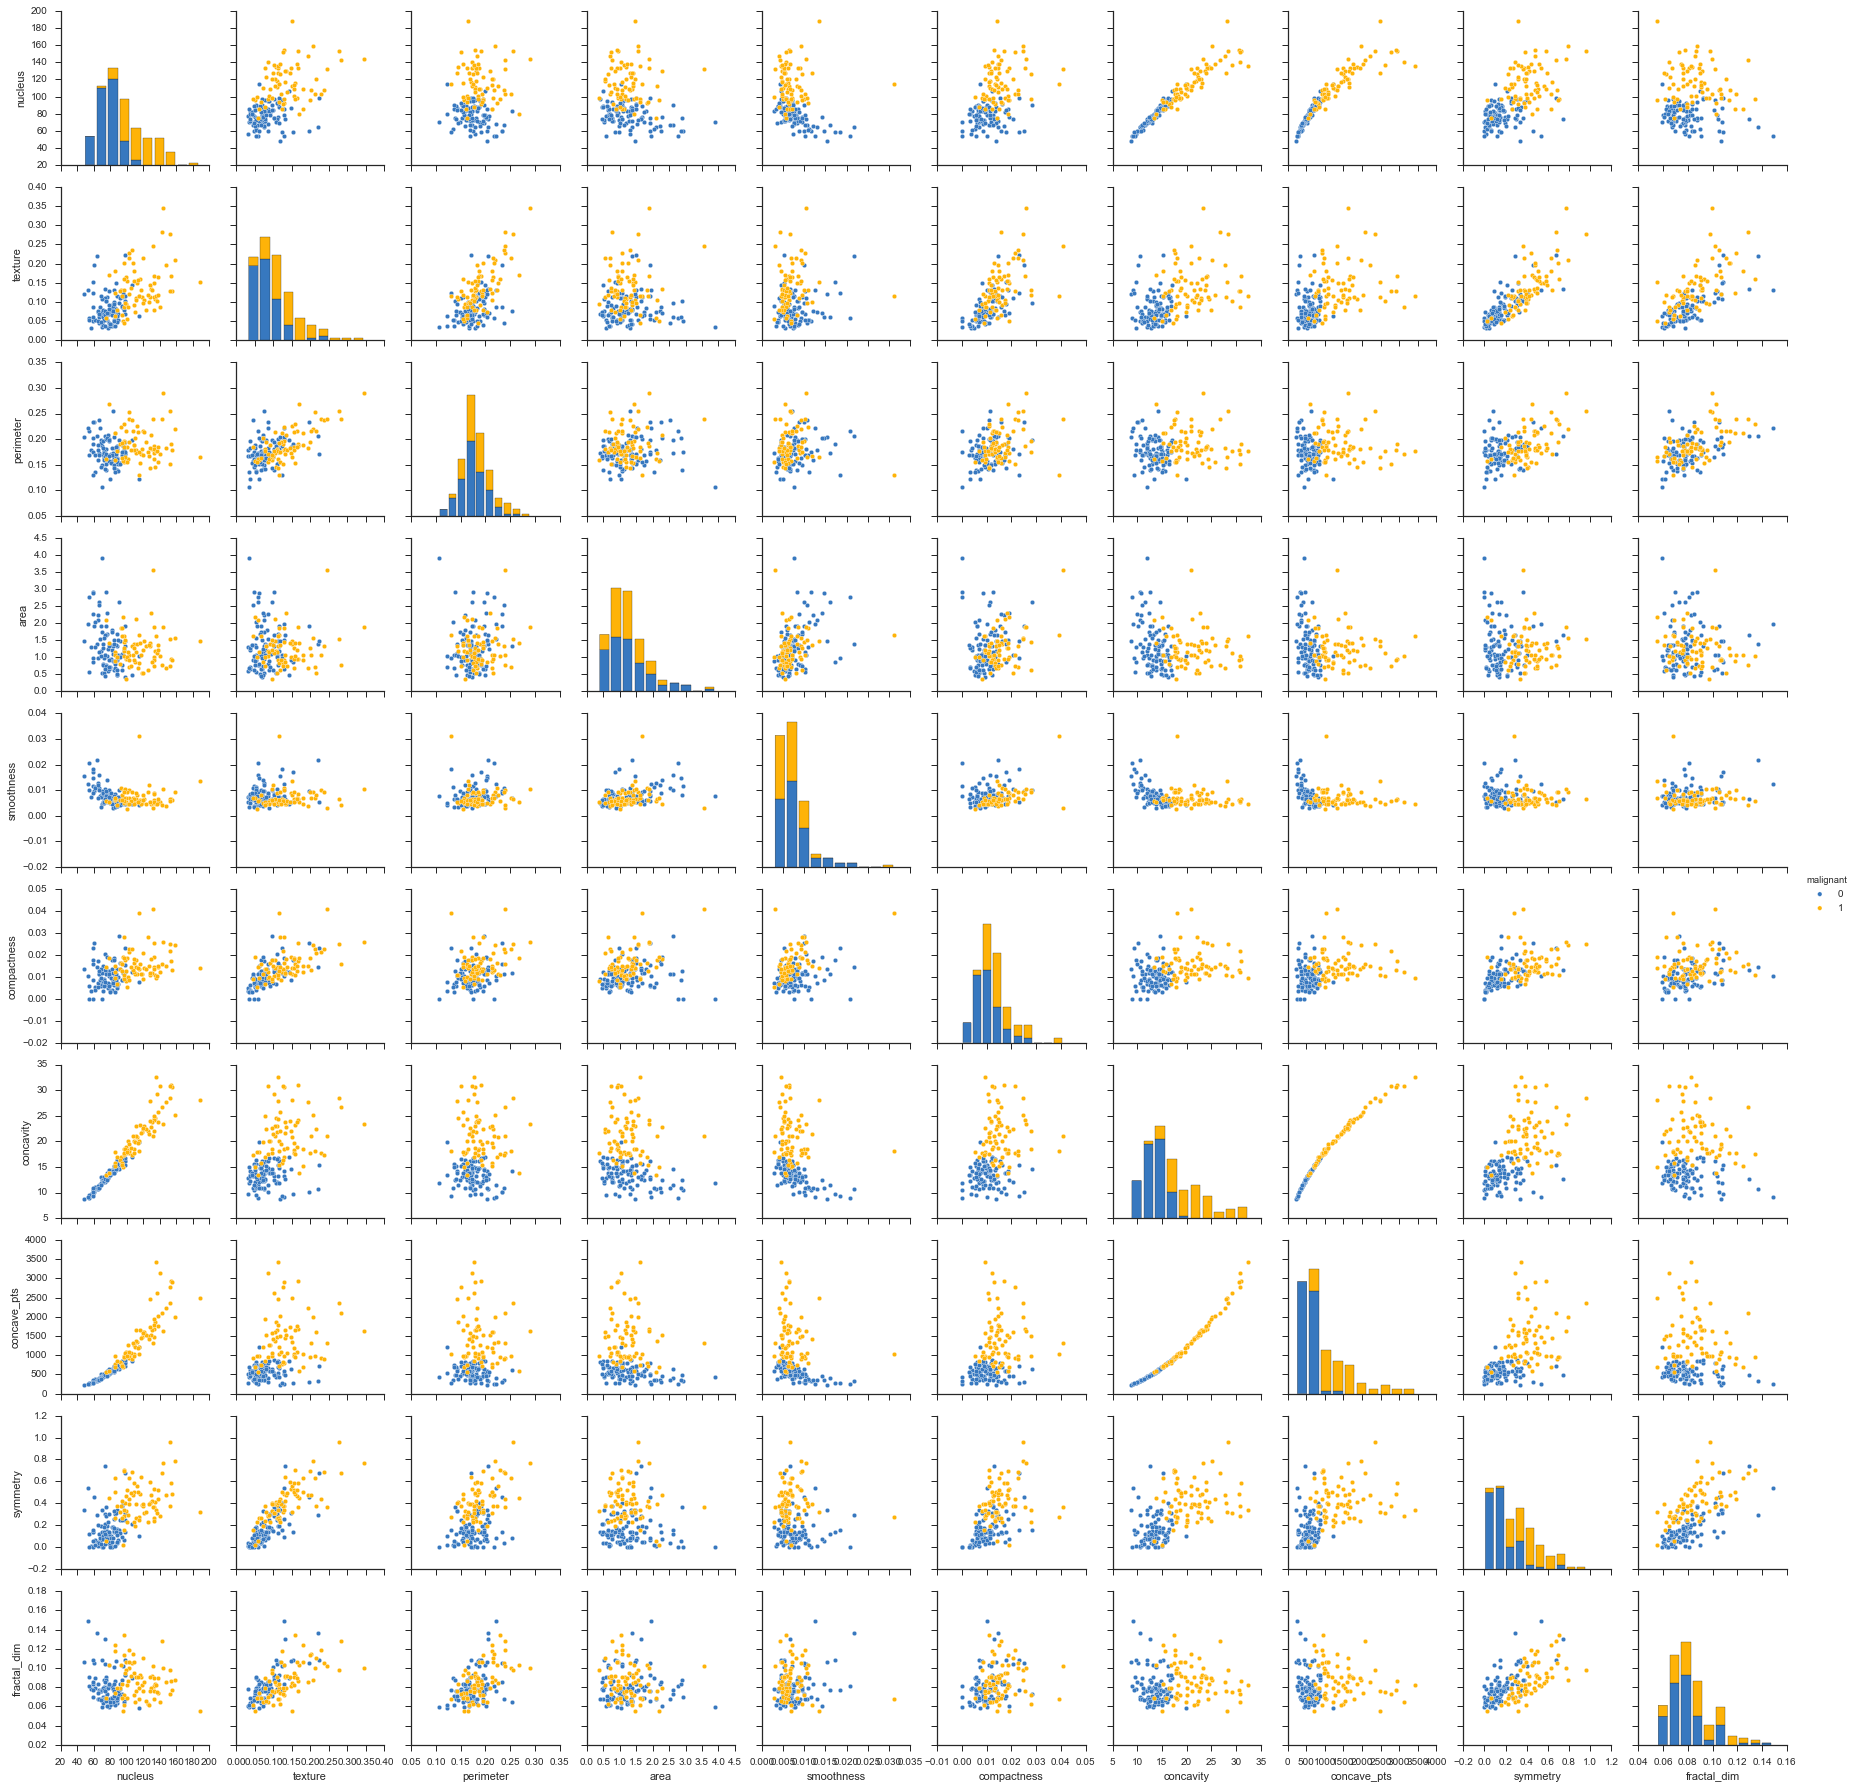

In [17]:
bcw_pairplotter(bcw_worst, colvars)

## 5. Test the performance of kNN classifiers on the data using cross-validation

Let's see how the kNN classifier performs on the dataset with cross-validation.

We are going to set some parameters in the classifier constructor. Some clarification below:

1. **n_neighbors** specifies how many neighbors will vote on the class
2. **weights** uniform weights indicate that all neighbors have the same weight
3. **metric** and **p** when distance is minkowski (the default) and p == 2 (the default), this is equivalent to the euclidean distance metric

Load scikit's handy cross-validation module.

The `cross_validation.StratifiedKFold()` function will return cross-validation indices which you can use to subset your data in a for loop that runs the model and tests it.

The **stratified** version of cross-validation ensures that there are equal proportions the predicted class in each train-test fold.

In [18]:
from sklearn import cross_validation

In [19]:
Y = bcw_mean['malignant'].values
X = bcw_mean[colvars].values

cv_indices = cross_validation.StratifiedKFold(Y, n_folds=5)

In [21]:
# Function to crossvalidate accuracy of a knn model acros folds
def accuracy_crossvalidator(X, Y, knn, cv_indices):
    
    # list to store the scores/accuracy of folds
    scores = []
    
    # iterate through the training and testing folds in cv_indices
    for train_i, test_i in cv_indices:
        
        # get the current X train & test subsets of X
        X_train = X[train_i, :]
        X_test = X[test_i, :]

        # get the Y train & test subsets of Y
        Y_train = Y[train_i]
        Y_test = Y[test_i]

        # fit the knn model on the training data
        knn.fit(X_train, Y_train)
        
        # get the accuracy predicting the testing data
        acc = knn.score(X_test, Y_test)
        scores.append(acc)
        
        print('Fold accuracy:', acc)
        
    print('Mean CV accuracy:', np.mean(scores))


### 5.2: Cross-validate accuracy for a kNN model with 5 neighbors on the mean data subset

In [22]:
mean_knn_n5 = KNeighborsClassifier(n_neighbors=5,
                                  weights='uniform',
                                  p=2,
                                  metric='minkowski')

accuracy_crossvalidator(X, Y, mean_knn_n5, cv_indices)

('Fold accuracy:', 0.86086956521739133)
('Fold accuracy:', 0.86956521739130432)
('Fold accuracy:', 0.89380530973451322)
('Fold accuracy:', 0.94690265486725667)
('Fold accuracy:', 0.90265486725663713)
('Mean CV accuracy:', 0.89475952289342042)


### 5.3: Cross-validate accuracy for a kNN model with 1 neighbor on the mean data subset

As you can see the mean cross-validated accuracy is very high with 5 neighbors. 

Let's see what it's like when we use only 1 neighbor:

In [23]:
mean_knn_n2 = KNeighborsClassifier(n_neighbors=1,
                              weights='uniform',
                              p=2,
                              metric='minkowski')

accuracy_crossvalidator(X, Y, mean_knn_n2, cv_indices)

('Fold accuracy:', 0.86086956521739133)
('Fold accuracy:', 0.86086956521739133)
('Fold accuracy:', 0.88495575221238942)
('Fold accuracy:', 0.87610619469026552)
('Fold accuracy:', 0.90265486725663713)
('Mean CV accuracy:', 0.8770911889188151)


### 5.4 Cross-validate accuracy for a kNN model with 5 neighbors on the standard error subset

In [24]:
Y = bcw_se['malignant'].values
X = bcw_se[colvars].values

se_knn_n2 = KNeighborsClassifier(n_neighbors=5,
                                 weights='uniform',
                                 p=2,
                                 metric='minkowski')

accuracy_crossvalidator(X, Y, se_knn_n2, cv_indices)

('Fold accuracy:', 0.86956521739130432)
('Fold accuracy:', 0.93043478260869561)
('Fold accuracy:', 0.92035398230088494)
('Fold accuracy:', 0.91150442477876104)
('Fold accuracy:', 0.94690265486725667)
('Mean CV accuracy:', 0.91575221238938054)


### 5.5 Cross-validate accuracy for a kNN model with 5 neighbors on the worst value subset

In [25]:
Y = bcw_worst['malignant'].values
X = bcw_worst[colvars].values

worst_knn_n2 = KNeighborsClassifier(n_neighbors=2,
                                    weights='uniform',
                                    p=2,
                                    metric='minkowski')

accuracy_crossvalidator(X, Y, worst_knn_n2, cv_indices)

('Fold accuracy:', 0.83478260869565213)
('Fold accuracy:', 0.87826086956521743)
('Fold accuracy:', 0.89380530973451322)
('Fold accuracy:', 0.92035398230088494)
('Fold accuracy:', 0.89380530973451322)
('Mean CV accuracy:', 0.8842016160061561)


## 6. Plot the kNN prediction boundary

Even with 1 neighbor we do quite well at predicting the malignant observations.

We will fit a kNN classifier with n_neighbors=5 using just **`nucleus`** and **`perimeter`** predicting the **`malignant`** class column.

The plotting function below will plot the points and the boundary of where the classifier votes between malignant vs. benign classes. 

---

Below is the helper function for plotting. All the sections are documented so you can walk through it and see how it works! (As usual, matplotlib code is not easy to read..)

In [26]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.colors as cl


# MOST OF THIS FUNCTION STUFF LIFTED FROM SCIKIT-LEARN EXAMPLE!
# see:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#example-neighbors-plot-classification-py

def knn_boundary_plotter(df, var1, var2, classvar='malignant',
                         nn=3, granularity=50.):
    
    # Subset the data to just the two variables to plot and the class variable
    df = df[[var1, var2, classvar]]
    
    # reset the index in case this matters..
    df.reset_index(drop=True, inplace=True)
    
    # get the point colors from a seaborn built in palette
    point_colors = sns.xkcd_palette(['windows blue', 'amber'])
    
    # set the mesh colors to be more "faded"/brighter versions of the point colors
    mesh_colors = ['#8FCCFF', '#FFED79']

    # the 'pcolormesh' matplotlib function requires we convert the mesh colors into a 
    # 'colormap'
    colormap = ListedColormap(mesh_colors)

    # fit a knn on the data with the nearest neighbors number passed into the function
    knn_mod = KNeighborsClassifier(n_neighbors=nn)
    knn_mod.fit(df[[var1, var2]].values, df[classvar].values)

    # get the minimum and maximum values for each of the predictor variables
    v1_min, v1_max = np.min(df[var1]), np.max(df[var1])
    v2_min, v2_max = np.min(df[var2]), np.max(df[var2])

    # get the range of each variable
    v1_range = v1_max - v2_min
    v2_range = v2_max - v2_min

    # set up the min and max ranges of the axes of the plot
    # I add a buffer here (1/15th of the range) so no points are on the axes
    buffer_denom =  15.
    
    x_min = v1_min - (v1_range/buffer_denom)
    x_max = v1_max + (v1_range/buffer_denom)
    
    y_min = v2_min - (v2_min/buffer_denom)
    y_max = v2_max + (v2_range/buffer_denom)

    # use the numpy meshgrid function to make a bunch of points across the range
    # of values.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, (v1_range/granularity)),
                         np.arange(y_min, y_max, (v2_range/granularity)))
    
    # Predict using the knn model on all the meshgrid points. This will let us see
    # the knn boundary of where it predicts between one class and another!
    Z = knn_mod.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # get out the values of our two predictors and class target variable
    v1_points = df[var1].values
    v2_points = df[var2].values
    class_colors = df[classvar].values

    # point size of 70 seems to work well
    point_sizes = 70

    # Set the figure size to be big enough to see stuff
    plt.figure(figsize=[11,9])
    
    # Plot the background colormesh colors, showing the decision boundary
    # of the fit k nearest neighbors algorithm:
    plt.pcolormesh(xx, yy, Z, cmap=colormap)

    # Plot the actual points of the 2 predictor variables
    plt.scatter(v1_points, v2_points, c=point_colors, s=point_sizes)
    
    # set the axis limits:
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Add the labels corresponding to the variables and a title
    # (I remembered this time, Sam!)
    plt.xlabel(var1, fontsize=20)
    plt.ylabel(var2, fontsize=20)
    plt.title('kNN='+str(nn)+' model predicting '+classvar+' with '+var1+' & '+var2+'\n',
              fontsize=20)


### 6.2 Use the boundary plotter function to plot area vs. symmetry using the mean value data and nn=3

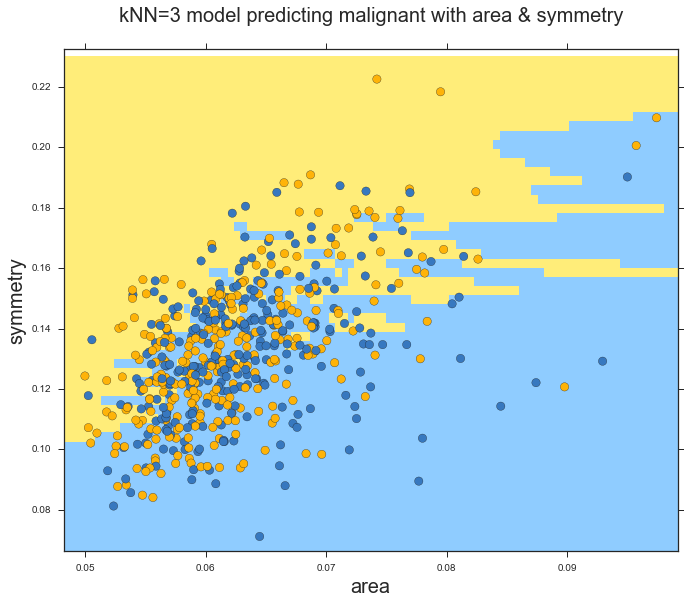

In [27]:
knn_boundary_plotter(bcw_mean, 'area', 'symmetry', nn=3)

### 6.3 Use the boundary plotter function to plot area vs. symmetry using the mean value data and nn=9

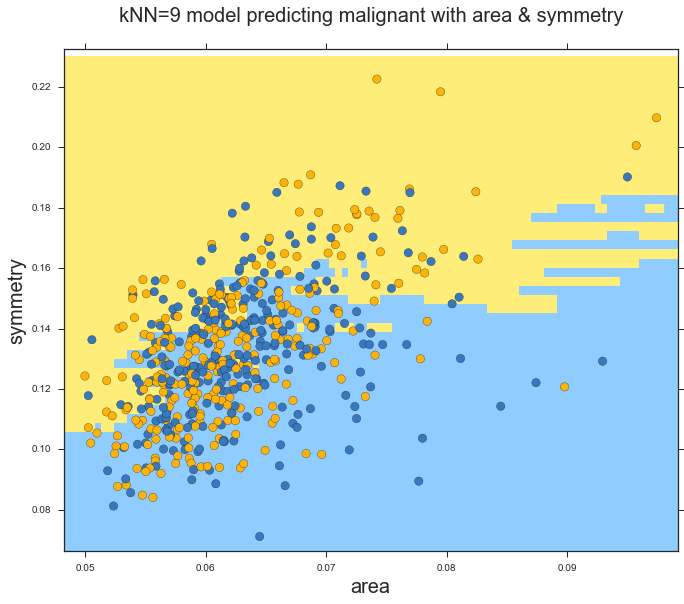

In [28]:
knn_boundary_plotter(bcw_mean, 'area', 'symmetry', nn=9)

### 6.4 Use the interactive widget to explore the effects of changing the knn values

Feel free to change the axis variables!

In [29]:
from ipywidgets import *

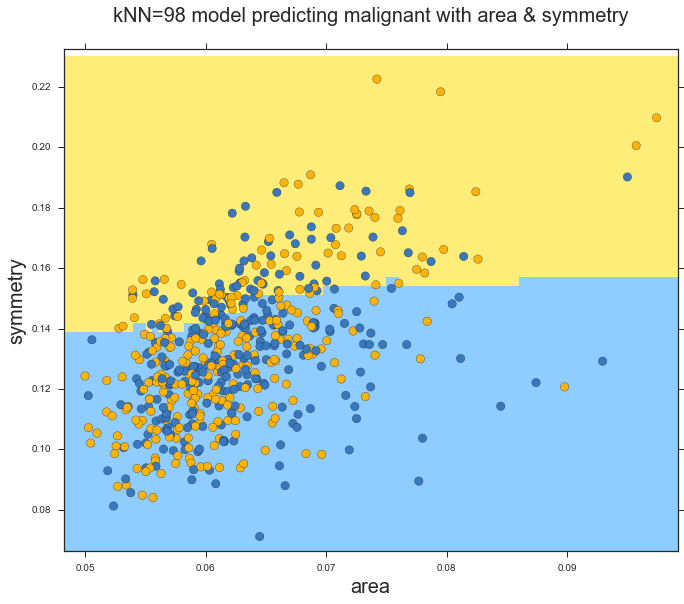

In [30]:
x_axis_var = 'area'
y_axis_var = 'symmetry'

def knn_area_symmetry_slider(nn):
    knn_boundary_plotter(bcw_mean, x_axis_var, y_axis_var, nn=nn)
    
widgets.interact(knn_area_symmetry_slider, 
                 nn=widgets.IntSlider(min=1, max=101, step=1, value=1))

## 7. What is the effect of increasing/decreasing the neighbors?

Increasing the neighbors "smooths out" the decision boundary.

## 8 What could be wrong with using accuracy as your measure of performance?

Accuracy does not tell us anything about the distribution of classes. You could have 100% accuracy, but if there is only 1 positive class and 100 negative classes, this is an inflated and misleading description of our model.

## 9. Examine more paired variables

Use the boundary plotter to look at how the number of neighbors affects 3 other pairs of variables.

Use cross-validation to see how changing the neighbor number affects the out-of-sample mean accuracy. 

## 10. Explain changing the number of neighbors in terms of bias-variance tradeoff

A higher number of neighbors increases bias and lowers variance. A lower number increases variance and decreases bias.

Predicting from 50 neighbors, for example, is more likely to be more distant from the true function across subsets of data, so bias is higher. However, because the predictions will be more consistent, the variance is lower.

Predicting from 1 neighbor, for example, has higher variance because the predictions are more likely to differ across different subsets of data. The bias is lower because the model is "trusting" the observed data more and minimizing the error between prediction and observation.

The appropriate tradeoff depends on the quality and quantity of the observed data in the sample.